Pip install's for remote GPU

In [1]:
!pip install torch
!pip install torchvision
!pip install numpy
!pip install torchmetrics
!pip install torchinfo
!pip install matplotlib
!pip install scikit-learn
!pip install pandas
!pip install pytorch-toolbelt
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 90.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=35cb7f6face410eb6d46e4a3733faafc2079f639123a1259cb1a906db37d29c7
  Stored in directory: /root/.cache/pip/wheels/22/16/f1/5369d23a06852d5f083d23a1addf0904575f1296f71b412ac8
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=759588794b436921c6795aef5ec0f04f9f7466029bb687

Imports

In [2]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision
import torchvision.models as models
from torchvision import *
from torchvision import datasets

from torchmetrics import *
from torchmetrics import JaccardIndex
from torchmetrics import Dice

from torch.utils.data import *

import sklearn as sk
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn import *
from sklearn import svm
from sklearn.metrics import jaccard_score
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import io, color

import segmentation_models_pytorch as smp

from PIL import Image

import pandas as pd

from itertools import compress

from tqdm import tqdm

from dataset import PolypsSegmentationDataset

Data Processing

In [3]:
# define path to images
image_path = './Kvasir-SEG'
size = 256
# get dataset, need resize to be divisible by 16 for all 4 max pools, to keep 
# dim the same of up transpose
# need tot check resize to see if random crop is correct
# and check to normalize
dataset = PolypsSegmentationDataset(image_path,size)
augmented_dataset = PolypsSegmentationDataset(image_path,size,True)

100%|██████████| 1000/1000 [00:00<00:00, 306287.72it/s]


In [4]:
# hyperparameters
BATCH_SIZE = 16
# converting dataset to dataloader, why does shuffle cause error?
# dataloader = DataLoader(dataset = dataset, batch_size = BATCH_SIZE)

Network

In [5]:
# loading unet model from pytorch
UNet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=64, pretrained=False)

/usr/local/lib/python3.9/dist-packages/torch/hub.py:266: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip


Training Methods

In [15]:
# Define the training function
def train(model, loss_fn, device, train_loader, optimizer, jaccard, dice):
    
    total_loss = 0
    total_iou = 0
    total_dice = 0
    
    for batch_idx, (X, y) in enumerate(train_loader):
        
        # get x and y
        X_train, y_train = X.to(device), y.to(device)
        model.train()
        # get output
        output = model(X_train).to(device)
        # compute loss
        print(f"Output: {output.shape} | Y: {y_train.shape}")
        loss = loss_fn(output, y_train)
        total_loss += loss.item()
        # compute IOU
        iou = jaccard(torch.where(output > 0.5, 1, 0),torch.where(y_train > 0.50, 1, 0))
        total_iou += iou
        # compute dice score
        dice_score = dice(torch.where(output > 0.5, 1, 0),torch.where(y_train > 0.50, 1, 0))
        total_dice += dice_score
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Train Loss: {total_loss / len(train_loader)} | Train IOU: {total_iou / len(train_loader)} | Train Dice: {total_dice / len(train_loader)}")
        

Training

In [13]:
# number of splits for data
splits = 10
# defining k-fold object
kf = KFold(splits,shuffle = True)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001
model = UNet.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr)
loss = torch.nn.BCELoss()
jaccard = JaccardIndex(task= 'BINARY',num_classes = 1, threshold = 0.5).to(device)
dice = Dice(average = 'micro', num_classes = 2, threshold = 0.5).to(device)

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)


Binary Cross Entropy Loss

In [16]:

torch.cuda.empty_cache()

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
    print(f"Fold: {fold + 1}")
    # get test loader
    train_loader = DataLoader(
        dataset=augmented_dataset,
        batch_size=BATCH_SIZE,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx)
        )
    # get train loader
    test_loader = DataLoader(
        dataset=dataset,
        batch_size=BATCH_SIZE,
        sampler=torch.utils.data.SubsetRandomSampler(test_idx),
    )
    #Train Model
    for i in range(5):
        train(model, loss, device, train_loader, optimizer, jaccard, dice)
    
    #Decays learning rate after each kfold
    lr_scheduler.step()
    
    #Evaluate model
    model.eval()
    test_loss = 0
    test_IOU = 0
    test_dice = 0
    with torch.inference_mode():
        for X, y in tqdm(test_loader):
            X, y = X.to(device), y.to(device)
            output = model(X)
            test_loss += loss(output, y).item()
            test_IOU += jaccard(torch.where(output > 0.5, 1, 0),torch.where(y > 0.50, 1, 0)).item()
            test_dice += dice(torch.where(output > 0.5, 1, 0),torch.where(y > 0.50, 1, 0)).item()

    
    test_loss /= len(test_loader)
    test_IOU /= len(test_loader)
    test_dice /= len(test_loader)
    print(f"Test set Average loss: {test_loss} | IOU: {test_IOU} | Dice: {test_dice}")
    

Fold: 1
Output: torch.Size([16, 1, 256, 256]) | Y: torch.Size([16, 1, 256, 256])
Output: torch.Size([16, 1, 256, 256]) | Y: torch.Size([16, 1, 256, 256])
Output: torch.Size([16, 1, 256, 256]) | Y: torch.Size([16, 1, 256, 256])
Output: torch.Size([16, 1, 256, 256]) | Y: torch.Size([16, 1, 256, 256])
Output: torch.Size([16, 1, 256, 256]) | Y: torch.Size([16, 1, 256, 256])
Output: torch.Size([16, 1, 256, 256]) | Y: torch.Size([16, 1, 256, 256])
Output: torch.Size([16, 1, 256, 256]) | Y: torch.Size([16, 1, 256, 256])
Output: torch.Size([16, 1, 256, 256]) | Y: torch.Size([16, 1, 256, 256])
Output: torch.Size([16, 1, 256, 256]) | Y: torch.Size([16, 1, 256, 256])
Output: torch.Size([16, 1, 256, 256]) | Y: torch.Size([16, 1, 256, 256])
Output: torch.Size([16, 1, 256, 256]) | Y: torch.Size([16, 1, 256, 256])
Output: torch.Size([16, 1, 256, 256]) | Y: torch.Size([16, 1, 256, 256])
Output: torch.Size([16, 1, 256, 256]) | Y: torch.Size([16, 1, 256, 256])
Output: torch.Size([16, 1, 256, 256]) | Y: 

KeyboardInterrupt: 

Jaccard Loss

In [77]:
loss = smp.losses.JaccardLoss('binary', log_loss = True)

In [78]:
torch.cuda.empty_cache()

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
    print(f"Fold: {fold + 1}")
    # get test loader
    train_loader = DataLoader(
        dataset= transformation(dataset),
        batch_size=BATCH_SIZE,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx)
        )
    # get train loader
    test_loader = DataLoader(
        dataset=dataset,
        batch_size=BATCH_SIZE,
        sampler=torch.utils.data.SubsetRandomSampler(test_idx),
    )
    #Train Model
    for i in range(5):
        train(model, loss, device, train_loader, optimizer, jaccard, dice)
    
    #Decays learning rate after each kfold
    lr_scheduler.step()
    
    #Evaluate model
    model.eval()
    test_loss = 0
    test_IOU = 0
    test_dice = 0
    with torch.inference_mode():
        for X, y in tqdm(test_loader):
            X, y = X.to(device), y.to(device)
            output = model(X)
            test_loss += loss(output, y).item()
            test_IOU += jaccard(torch.where(output > 0.5, 1, 0),torch.where(y > 0.50, 1, 0)).item()
            test_dice += dice(torch.where(output > 0.5, 1, 0),torch.where(y > 0.50, 1, 0)).item()

    
    test_loss /= len(test_loader)
    test_IOU /= len(test_loader)
    test_dice /= len(test_loader)
    print(f"Test set Average loss: {test_loss} | IOU: {test_IOU} | Dice: {test_dice}")

Fold: 1
Train Loss: 1.8912871239478128 | Train IOU: 0.34438207745552063 | Train Dice: 0.875787079334259
Train Loss: 1.8938223500000804 | Train IOU: 0.3476663827896118 | Train Dice: 0.8780691623687744
Train Loss: 1.8956623537498607 | Train IOU: 0.3487612009048462 | Train Dice: 0.8775914311408997


KeyboardInterrupt: 

Testing

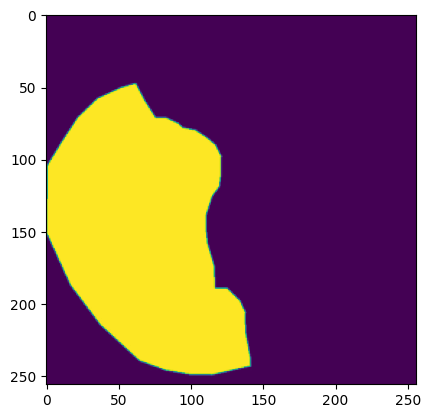

In [33]:
plt.imshow(y[3].cpu().permute(1,2,0))

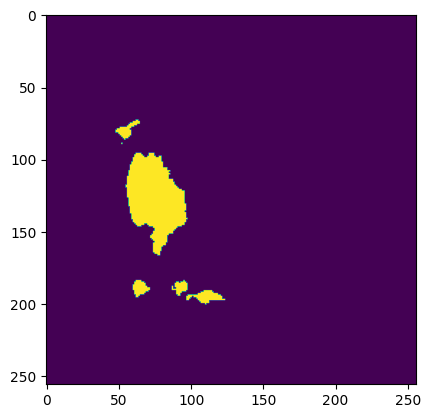

In [36]:
x = torch.where(output > 0.5, 1, 0)
plt.imshow(x[3].cpu().permute(1,2,0))

In [54]:
print(jaccard(torch.where(output > 0.35, 1, 0),torch.where(y > 0.40, 1, 0)))

tensor(0.2342, device='cuda:0')


In [38]:
#print(loss(output,y))

print(dice(torch.where(output > 0.50, 1, 0),torch.where(y > 0.40, 1, 0)))

TypeError: update() got an unexpected keyword argument 'num_classes'

In [19]:
test_loss = 0
with torch.inference_mode():
    for X, y in tqdm(test_loader):
        X, y = X.to(device), y.to(device)
        output = model(X)
        test_loss += loss(output, y).item()
        print(f"Loss: {test_loss}")

  8%|▊         | 1/13 [00:00<00:07,  1.62it/s]

Loss: 0.3947315812110901


 15%|█▌        | 2/13 [00:01<00:08,  1.29it/s]

Loss: 0.7293487787246704


 23%|██▎       | 3/13 [00:02<00:08,  1.25it/s]

Loss: 1.0140481293201447


 31%|███       | 4/13 [00:02<00:05,  1.54it/s]

Loss: 1.4639271199703217


 38%|███▊      | 5/13 [00:03<00:04,  1.82it/s]

Loss: 1.7604164779186249


 46%|████▌     | 6/13 [00:03<00:03,  2.09it/s]

Loss: 2.129318207502365


 54%|█████▍    | 7/13 [00:03<00:02,  2.31it/s]

Loss: 2.4442706406116486


 62%|██████▏   | 8/13 [00:04<00:02,  2.48it/s]

Loss: 2.740805983543396


 69%|██████▉   | 9/13 [00:04<00:01,  2.65it/s]

Loss: 3.0997469425201416


 77%|███████▋  | 10/13 [00:04<00:01,  2.76it/s]

Loss: 3.425353080034256


 85%|████████▍ | 11/13 [00:05<00:00,  2.85it/s]

Loss: 3.699008136987686


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]

Loss: 4.033684074878693
Loss: 4.262686043977737


In [20]:
test_loss / len(test_loader)

0.32789892645982593

In [23]:
model.eval()
test_loss = 0
test_accuracy = 0
with torch.inference_mode():
    for X, y in tqdm(test_loader):
        X, y = X.to(device), y.to(device)
        output = model(X)
        test_loss += loss(output, y).item()
        test_accuracy += jaccard(torch.where(output > 0.40, 1, 0),torch.where(y > 0.40, 1, 0)).item()




  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


In [25]:
test_loss / len(test_loader)

0.33271955297543454